# LIBROSA DEMO

In [1]:
# IMPORTING FUTURE
from __future__ import print_function

In [2]:
# IMPORTING FUTURE
import numpy as np
import pandas as pd
import librosa
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
#FILTER WARNINGS
import warnings
warnings.filterwarnings('ignore')

### LOADING AUDIO

In [19]:
PATH = 'external_media/'
FILE = 'test_1.wav'
y, sr = librosa.load(PATH+FILE)

In [20]:
print(y.size, sr)
print(type(y), type(sr))

741390 22050
<class 'numpy.ndarray'> <class 'int'>


### MEL SPECTOGRAM

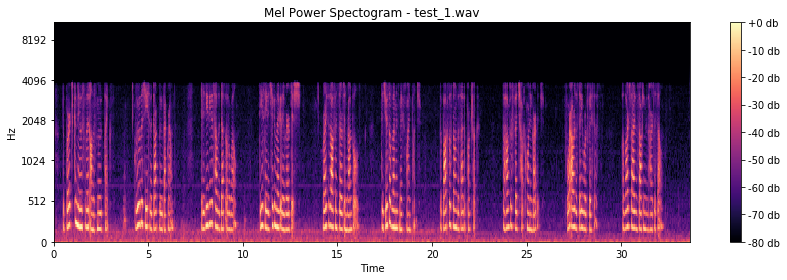

In [25]:
# Display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

#Convert to log scale (dB). We'll use the peak power (max) as reference
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel Power Spectogram - '+FILE)
plt.colorbar(format='%+02.0f db')
plt.tight_layout()

### HARMONIC-PERCUSSIVE SOURCE SEPARATION

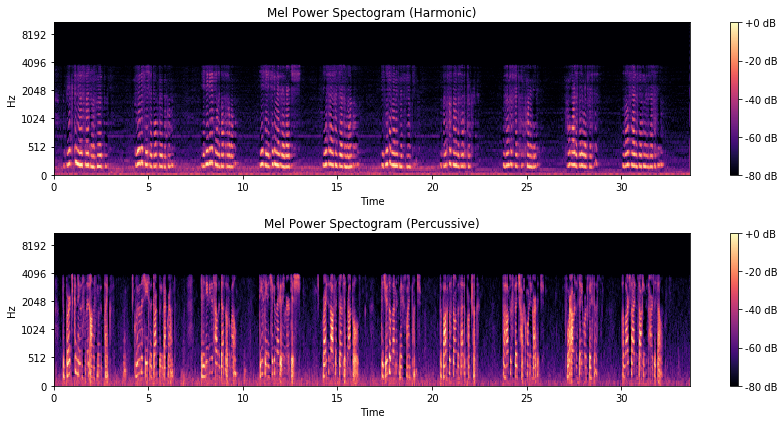

In [27]:
harmonic, percussive = librosa.effects.hpss(y)

harmonic_S = librosa.feature.melspectrogram(harmonic, sr=sr)
percussive_S = librosa.feature.melspectrogram(percussive, sr=sr)

log_aS = librosa.power_to_db(harmonic_S, ref=np.max)
log_pS = librosa.power_to_db(percussive_S, ref=np.max)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
librosa.display.specshow(log_aS, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel Power Spectogram (Harmonic)')
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_pS, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel Power Spectogram (Percussive)')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

### CHRONOGRAM

In [28]:
# chroma feature or chromagram closely relates to the twelve different pitch classes. 
# One main property of chroma features is that they capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation. 

In [30]:
# CQT / Constant-Q Transform transforms a data series to the frequency domain. It is related to the Fourier transform[1] and very closely related to the complex Morlet wavelet transform.
# CQT uses a logarithmically spaced frequency axis.

In [31]:
# We'll use a CQT-based chromagram here.  An STFT-based implementation also exists in chroma_cqt()
# We'll use the harmonic component to avoid pollution from transients

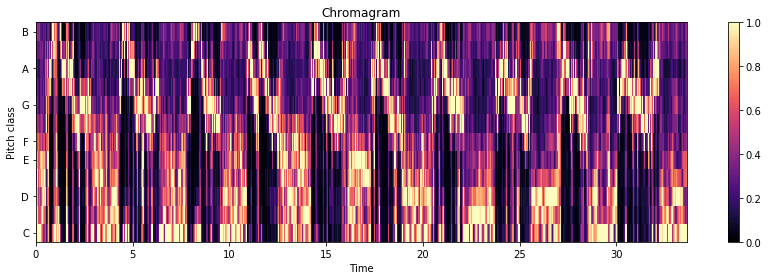

In [35]:
C = librosa.feature.chroma_cqt(y=harmonic, sr=sr)

plt.figure(figsize=(12,4))

# Display the chromagram: the energy in each chromatic pitch class as a function of time
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()

### MFCC (MEL FREQUENCY CEPSTRAL COEFFICIENT) 

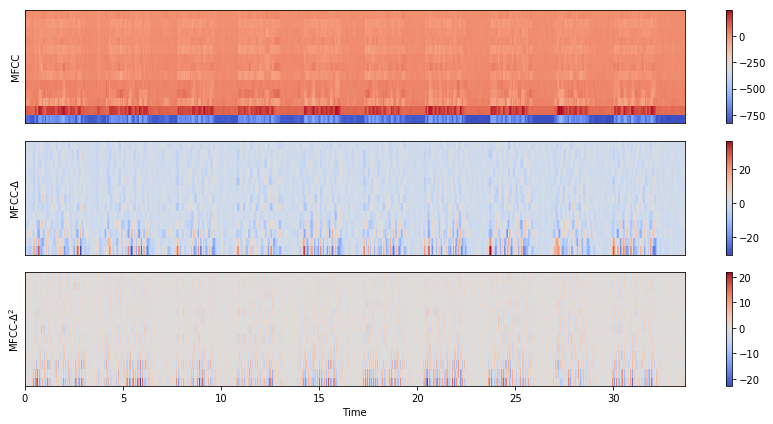

In [37]:
# we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

delta_mfcc = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()
plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

### BEAT TRACKING

In [38]:
# The beat tracker returns an estimate of the tempo (in beats per minute) and frame indices of beat events

Estimated tempo:        123.05 BPM
First 5 beat frames:    [11 32 49 72 95]
First 5 beat times:     [0.2554195  0.74303855 1.13777778 1.67183673 2.20589569]


<Figure size 864x432 with 0 Axes>

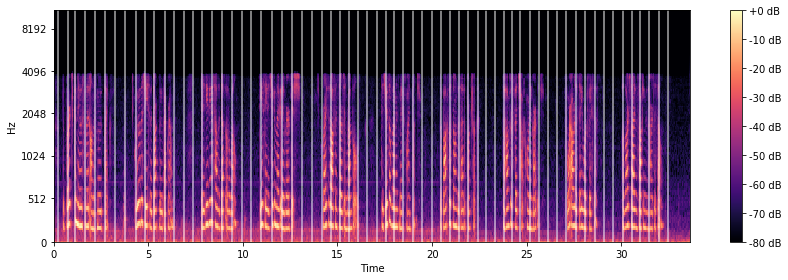

In [44]:
plt.figure(figsize=(12, 6))
tempo, beats = librosa.beat.beat_track(y=percussive, sr=sr, trim=False)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

#Let's draw transparent lines over the beat frames
plt.vlines(librosa.frames_to_time(beats),1, 0.5 * sr,colors='w', linestyles='-', linewidth=2, alpha=0.5)

plt.axis('tight')

plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

print('Estimated tempo:        %.2f BPM' % tempo)
print('First 5 beat frames:   ', beats[:5])
# Frame numbers are great and all, but when do those beats occur?
print('First 5 beat times:    ', librosa.frames_to_time(beats[:5], sr=sr))
# We could also get frame numbers from times by librosa.time_to_frames()

### BEAT-SYNCRHONOUS FEATURE AGGREGATION

In [45]:
#Once we've located the beat events, we can use them to summarize the feature content of each beat.
#This can be useful for reducing data dimensionality, and removing transient noise from the features.

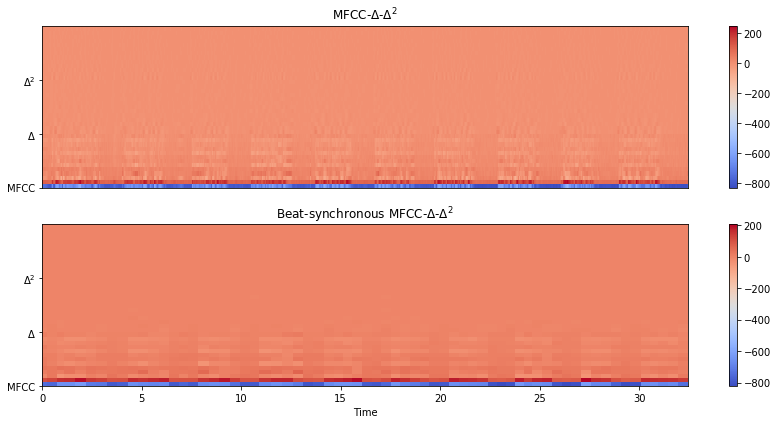

In [46]:
# feature.sync will summarize each beat event by the mean feature vector within that beat

M_sync = librosa.util.sync(M, beats)

plt.figure(figsize=(12,6))

# Let's plot the original and beat-synchronous features against each other
plt.subplot(2,1,1)
librosa.display.specshow(M)
plt.title('MFCC-$\Delta$-$\Delta^2$')

# We can also use pyplot *ticks directly
# Let's mark off the raw MFCC and the delta features
plt.yticks(np.arange(0, M.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])

plt.colorbar()

plt.subplot(2,1,2)
# librosa can generate axis ticks from arbitrary timestamps and beat events also
librosa.display.specshow(M_sync, x_axis='time',
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))

plt.yticks(np.arange(0, M_sync.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])             
plt.title('Beat-synchronous MFCC-$\Delta$-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

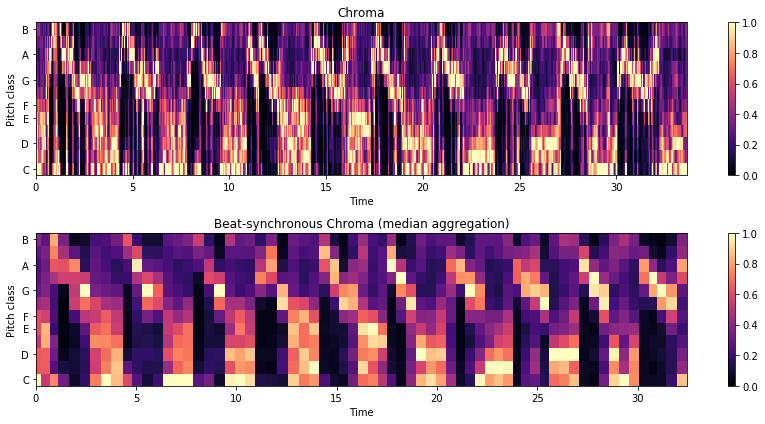

In [47]:
# Beat synchronization is flexible.
# Instead of computing the mean delta-MFCC within each beat, let's do beat-synchronous chroma
# We can replace the mean with any statistical aggregation function, such as min, max, or median.

C_sync = librosa.util.sync(C, beats, aggregate=np.median)

plt.figure(figsize=(12,6))

plt.subplot(2, 1, 1)
librosa.display.specshow(C, sr=sr, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time')

plt.title('Chroma')
plt.colorbar()

plt.subplot(2, 1, 2)
librosa.display.specshow(C_sync, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time', 
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))


plt.title('Beat-synchronous Chroma (median aggregation)')

plt.colorbar()
plt.tight_layout()